In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
from itertools import combinations
from tkinter import filedialog, messagebox
import tkinter as tk
import PIL
from PIL import Image
import tifffile as tif

btn_down = False

In [10]:
def TestBox(): messagebox.showinfo(message="Todo ok!",title="Mensaje")

class Starshot:

    def ElegirArchivos(self):
        tk.Tk().withdraw()
        filename =  filedialog.askopenfilenames(title='Seleccionar imagen', 
                                                filetypes=(('Imagen TIF','*.tif'), ('Imagen TIFF','*.tiff'), ('All Files','*.')))
        return filename

    def __init__(self, PROMEDIADO, tipo, dpi): 
        self.tipo = tipo  
        self.dpi = dpi
        self.path = list(self.ElegirArchivos())    #Si se eligen varias imagenes, self.path es una lista de paths
        # print(self.path)
        # self.path = ['P:/8 - Físicos Médicos/Roy/QA Starshot/inca electrones 29-05-2024/STARSHOT_COL001.tif']
        # print(path2)
        
        if PROMEDIADO:
            imagenes = []
            for path in self.path:
               imagen = np.array(tif.imread(path), np.uint16)
               #  print(type(imagen), imagen.shape)
               #Invierte y elegi canal
               imagen_invertida = np.invert(imagen[:,:,1])   # Green 
               imagenes.append(imagen_invertida)

            pila_imagenes = np.stack(imagenes, axis=0)
            imagen_promedio = np.mean(pila_imagenes, axis=0)
            self.imagen = np.uint16(imagen_promedio)
        else:                        
            imagen = np.array(tif.imread(path), np.uint16)
            #Invierte y elegi canal
            imagen_invertida = np.invert(imagen[:,:,1])   # Green 
            self.imagen = np.uint16(imagen_invertida)

        # print(self.imagen.min(),self.imagen.max())
        # print(self.imagen)
        
        
def get_points(im):
    # Set up data to send to mouse handler
    data = {}
    data['im'] = im.copy()
    data['lines'] = []

    # Set the callback function for any mouse event
    cv2.imshow("Image", im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)

    # Convert array to np.array in shape n,2,2
    points = np.uint16(data['lines'])

    return points, data['im']

def mouse_handler(event, x, y, flags, data):
    global btn_down

    if event == cv2.EVENT_MOUSEMOVE:
        draw_lines(data['im'], x, y)

    if event == cv2.EVENT_LBUTTONUP and btn_down:
        #if you release the button, finish the line
        btn_down = False
        data['lines'][0].append((x, y)) #append the second point

        radio = int(  np.sqrt( (data['lines'][0][0][0]-data['lines'][0][1][0])**2 + 
              (data['lines'][0][0][1]-data['lines'][0][1][1])**2 )   )

        xi = int(data['lines'][0][0][0])
        yi = int(data['lines'][0][0][1])
        cv2.circle(data['im'], (xi, yi), 2, (255, 0, 0), thickness=1)
        cv2.circle(data['im'],(xi,yi),radio,(255,0,0), thickness=1)

        cv2.imshow("Image", data['im'])

    elif event == cv2.EVENT_MOUSEMOVE and btn_down:
        #thi is just for a line visualization
        image = data['im'].copy()
        cv2.line(image, data['lines'][0][0], (x, y), (0,0,0), 1)
        cv2.imshow("Image", image)

    elif event == cv2.EVENT_LBUTTONDOWN and len(data['lines']) < 1:
        btn_down = True
        data['lines'].insert(0,[(x, y)]) #prepend the point
        cv2.imshow("Image", data['im'])

# def get_points(im):
#     # Set up data to send to mouse handler
#     data = {}
#     data['im'] = im.copy()

#     # Set the callback function for any mouse event
#     cv2.imshow("Image", im)
#     cv2.setMouseCallback("Image", mouse_handler, data)

#     while True:
#         key = cv2.waitKey(1) & 0xFF
#         if key == ord('q'):
#             break

#         # Convert array to np.array in shape n,2,2
#         points = np.array([])

#         return points, data['im']

# def mouse_handler(event, x, y, flags, data):
#     if event == cv2.EVENT_MOUSEMOVE:
#         draw_lines(data['im'], x, y)

def draw_lines(im, x, y):
    img_copy = im.copy()
    height, width = img_copy.shape[:2]

    # Dibujar línea horizontal
    cv2.line(img_copy, (0, y), (width, y), (0, 0, 255), 1)

    # Dibujar línea vertical
    cv2.line(img_copy, (x, 0), (x, height), (0, 0, 255), 1)

    cv2.imshow("Image", img_copy)



def Procesamiento(imagen):
  # roi_size = radio_px
  size_r = imagen.shape[0]  #nro filas
  size_c = imagen.shape[1]  #nro columnas
  roi_size = int(size_r) #asumo que la imagen siempre tiene mas columnas que filas

  roi = imagen[ int((size_r-roi_size)/2):int((size_r+roi_size)/2),
					                int((size_c-roi_size)/2):int((size_c+roi_size)/2) ]

  # plt.imshow(imagen)
  # plt.show()
  # plt.imshow(roi)
  # plt.show()

  return roi

def PerfilStarshots(img, centro_x, centro_y, radio, ancho, dpi, interpolation_flag):
  #--- the following holds the square root of the sum of squares of the image dimensions ---
  #--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---

  img_blur = cv2.GaussianBlur(img, (9, 9), 0)
  # plt.imshow(np.concatenate((img, img_blur), axis=1));
  img = img_blur
  # plt.figure()
  # plt.plot(img[100,:])
  # plt.show()

  CENTRO_IGUAL_A_CENTRO_ROI = False

  if CENTRO_IGUAL_A_CENTRO_ROI:
    centro_x_px = int(img.shape[0]/2)
    centro_y_px = int(img.shape[1]/2)
  else:
    centro_x_px = int(centro_x*dpi/25.4)
    centro_y_px = int(centro_y*dpi/25.4)

  radio_max_polar = int((radio+ancho/2)*dpi/25.4)

  ancho_px = int(ancho*dpi/25.4)

  polar_image = cv2.linearPolar(img,(centro_x_px, centro_y_px), radio_max_polar, interpolation_flag)
  
  # print(polar_image.min(),polar_image.max())

  # polar_image = polar_image.astype(np.uint16)

  # print(polar_image.min(),polar_image.max())

  # polar_image = polar_image[:,int(polar_image.shape[1]*15/16):]

  # print(polar_image.min(),polar_image.max())

  # cv2.imshow("Polar Image", polar_image)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

  perfil = polar_image[:,-ancho_px:]

  perfil = np.mean(perfil, axis=1)

  phi = np.arange(0,perfil.shape[0])*360/perfil.shape[0] #angulo en grados pero cada 360/len(perfil)

  plt.figure()
  plt.plot(phi,perfil)
  plt.ylabel('Intensidad de pixel')
  plt.ylim([perfil.min(), perfil.max()])
  plt.xlim([phi.min(),phi.max()])
  plt.xlabel('Angulo polar [º]')
  plt.show()

  return phi, perfil

def Coordenadas(phi,perfil,threshold, radio):

  def _gauss(x, a, mu, sig):
      return a*np.exp(-(x-mu)**2/(2*sig**2))

  def gauss_fit(x, y, xmin, xmax):
      fitx = x[(x>xmin)*(x<xmax)]
      fity = y[(x>xmin)*(x<xmax)]
      mu = np.sum(fitx*fity)/np.sum(fity)
      sig = np.sqrt(np.sum(fity*(fitx-mu)**2)/np.sum(fity))

      popt, pcov = curve_fit(_gauss, fitx, fity, p0=[max(fity), mu, sig])
      return popt[0], popt[1], popt[2]

  def CondicionaPerfil(phi,perfil,threshold):
    if perfil[0]>promedio:  #este es el caso en el que el primer pico esta cortado
      for i in range(len(perfil)):
        if (perfil[i]<promedio): 
          n = i+1
          break
      perfil2 = np.concatenate( ( perfil[n:], perfil[:n]) , axis=0 )
      aux     = phi[:n] + 360.0
      phi2    = np.concatenate( ( phi[n:], aux) , axis=0 )
    else:
      perfil2 = perfil
      phi2    = phi
    return phi2,perfil2

  promedio = threshold
  idx = []
  parametros = []
  rangos = []

  phi2,perfil2 = CondicionaPerfil(phi,perfil,promedio)

  for i in range(len(perfil2)):
    if(perfil2[i]>=promedio):
      idx.append(i)
    if(perfil2[i]<promedio and idx):
      pmin = phi2[ idx[0]  ]
      pmax = phi2[ idx[-1] ]
      rangos.append( (pmin,pmax) )
      parametros.append( gauss_fit(phi2[idx], perfil2[idx], pmin, pmax) )
      idx = []
      continue

  #Calculo angulos de los spokes: theta
  theta = np.array(parametros).transpose()[1]
  for i in range(theta.shape[0]):
    if theta[i]>=360: theta[i] = theta[i] - 360
  theta = np.sort(theta, axis=0)

  #calculo sus radios = r
  radius = [radio] * theta.shape[0]    #radio sale de las celdas anteriores #mm

  plt.plot(phi,perfil, linewidth=1)
  for i in range(len(parametros)):
    plt.axvline(x = theta[i] , color='g', linewidth=0.5)
  plt.ylabel('Intensidad de pixel')
  plt.ylim([perfil.min(), perfil.max()])
  plt.xlim([phi.min(),phi.max()])
  plt.xlabel('Angulo polar [º]')
  plt.show()

  return theta, radius

def CoeficientesRectas(theta,radius):

  rectas = []

  # fig = plt.figure()
  # ax = fig.add_subplot(111)
  marker = ['.','o','*','D','+','v']
  colour = ['b','g','r','c','k','m']

  for i in range(theta.shape[0]//2):
    p1_r,p1_phi = ( radius[i]                   , theta[i]                   )
    p2_r,p2_phi = ( radius[i+theta.shape[0]//2] , theta[i+theta.shape[0]//2] )

    p1_x,p1_y = ( p1_r*np.cos(p1_phi*np.pi/180.0) , p1_r*np.sin(p1_phi*np.pi/180.0) )
    p2_x,p2_y = ( p2_r*np.cos(p2_phi*np.pi/180.0) , p2_r*np.sin(p2_phi*np.pi/180.0) )

    # plt.scatter(p1_x,p1_y, marker=marker[i], color=colour[i])
    # plt.scatter(p2_x,p2_y, marker=marker[i], color=colour[i])

    a = (p1_y - p2_y) / (p1_x - p2_x)
    b = p1_y - a * p1_x
    rectas.append( [a,b] )

  # x = np.arange(-100,100,2)

  # for i in range(len(rectas)):
  #   y = rectas[i][0] * x + rectas[i][1]
  #   if (i==0 or i==2 or i==3):  plt.plot(x,y)
  #   #plt.plot(x,y)

  # ax.set_aspect('equal', adjustable='box')
  # plt.ylim(1, 5) #mm
  # plt.xlim(1, 5) #mm
  # plt.grid('on')
  # plt.ylabel('Distancia [mm]')
  # plt.xlabel('Distancia [mm]')
  # plt.show()

  a = np.array(rectas)[:,0]
  b = np.array(rectas)[:,1]

  return a,b

def SolucionStarshot(a,b, radio):

  def d2(x): return (x[2]-x[0])**2+(x[3]-x[1])**2

  def EncuentraMenorCirculo(i,j,k,a,b):

    cons = ({'type': 'eq', 'fun': lambda x: a[i]*x[2] + b[i] - x[3] },
            {'type': 'eq', 'fun': lambda x: a[j]*x[4] + b[j] - x[5] },
            {'type': 'eq', 'fun': lambda x: a[k]*x[6] + b[k] - x[7] },
            {'type': 'eq', 'fun': lambda x: (x[4]-x[0])**2 + (x[5]-x[1])**2 - (x[6]-x[0])**2 - (x[7]-x[1])**2 },
            {'type': 'eq', 'fun': lambda x: (x[2]-x[0])**2 + (x[3]-x[1])**2 - (x[6]-x[0])**2 - (x[7]-x[1])**2 }
             )

    xcero = np.random.uniform(-50,50,8)
    bnds = ( (-radio,radio), (-radio,radio), (-radio,radio), (-radio,radio), 
             (-radio,radio), (-radio,radio), (-radio,radio), (-radio,radio) )

    res = minimize(d2,xcero,method='SLSQP', tol=1E-6, bounds=bnds, constraints=cons)

    return np.sqrt( (res.x[2]-res.x[0])**2 + (res.x[3]-res.x[1])**2 ), res.x[0], res.x[1]

  resultados = []

  for i,j,k in combinations(np.arange(a.shape[0]),3):
    resultados.append( EncuentraMenorCirculo(i,j,k,a,b) )

  resultados = np.array(resultados).T.tolist()

  idx_max = resultados[0].index(max(resultados[0]))

  diametro = resultados[0][idx_max]*2
  x0       = resultados[1][idx_max]
  y0       = resultados[2][idx_max]

  return diametro, x0, y0

def Grafico(a,b,diametro,x0,y0, starshot_tipo):

  x = np.arange(-100,100,2)

  fig = plt.figure()
  ax = fig.add_subplot(111)

  for i in range(len(a)):
    y = a[i] * x + b[i]
    plt.plot(x,y)
  plt.plot(x0,y0, marker='o')
  a_Circle = plt.Circle( (x0,y0), diametro/2, fill=False)
  ax.add_artist(a_Circle)

  ax.set_aspect('equal', adjustable='box')
  # plt.xlim(x0-2.5*diametro, x0+2.5*diametro) #mm
  # plt.ylim(y0-2.5*diametro, y0+2.5*diametro) #mm
  zoom = 3
  plt.xlim(-zoom, zoom) #mm
  plt.ylim(-zoom, zoom) #mm
  plt.grid('on')
  plt.ylabel('Distancia [mm]')
  plt.xlabel('Distancia [mm]')
  plt.text(x0-2*diametro,y0-2*diametro, 'Diametro = '+str(round(diametro,1))+' mm', 
                                  fontsize = 12)
  plt.savefig(starshot_tipo+'.png', dpi=300, bbox_inches='tight')
  plt.show()


def AnalisisStarshot(starshot_tipo, PROMEDIADO, threshold, ancho, dpi, radio, interpolation_flag):
    starshot = Starshot(PROMEDIADO, tipo=starshot_tipo, dpi=dpi)
    imagen = Procesamiento(starshot.imagen)

    btn_down = False

    DEBUG_MODE = False

    if DEBUG_MODE:
       pts = [[[382, 303],[376, 545]]]
    else:
       pts, final_image = get_points(imagen)

    xi = float(pts[0][0][0])*25.4/dpi
    yi = float(pts[0][0][1])*25.4/dpi
    xf = float(pts[0][1][0])*25.4/dpi
    yf = float(pts[0][1][1])*25.4/dpi

    if radio is None:
      if DEBUG_MODE:
        radio = radio
      else:
        radio = np.sqrt( (xi-xf)**2 + (yi-yf)**2 )

    print(f'X0 = ({xi},{yi})   radio = {radio} mm')

    phi, perfil = PerfilStarshots(imagen, xi, yi, radio=radio, ancho=ancho, dpi=dpi, interpolation_flag=interpolation_flag)

    theta, radius = Coordenadas(phi,perfil,threshold, radio)

    #Calculo de las rectas
    a, b = CoeficientesRectas(theta,radius)

    diametro, x0, y0 = SolucionStarshot(a,b, radio=radio)

    desplazamiento = np.sqrt(x0*x0+y0*y0)

    print(f'Desplazamiento radiante vs optico: {desplazamiento:.1f} mm')

    Grafico(a,b,diametro,x0,y0,starshot_tipo)



X0 = (97.36666666666666,95.95555555555555)   radio = 35 mm


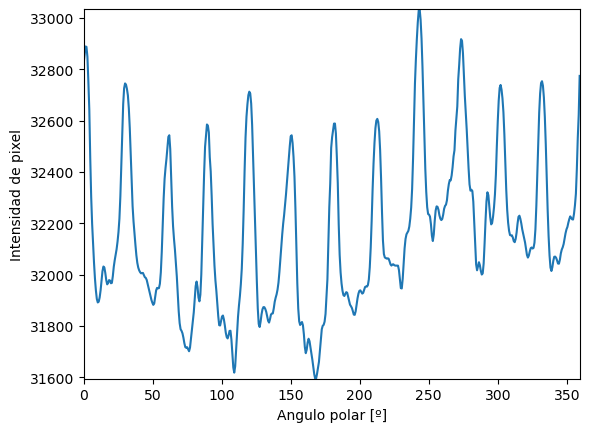

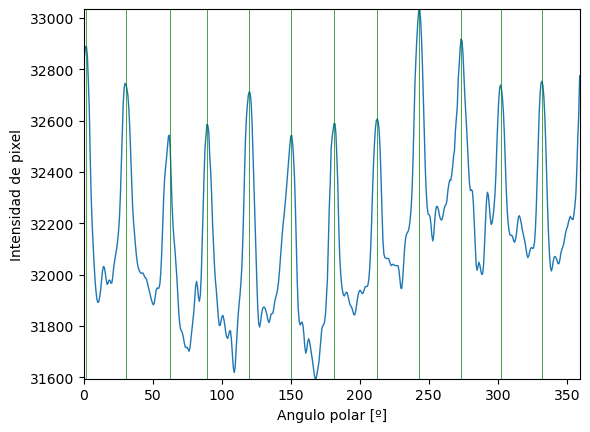

Desplazamiento radiante vs optico: 0.8 mm


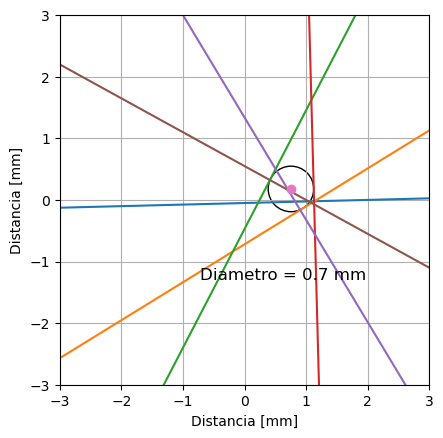

In [11]:
AnalisisStarshot(starshot_tipo='colimador', PROMEDIADO=True, threshold=32400, ancho=15, dpi=72, radio=35, interpolation_flag=cv2.WARP_FILL_OUTLIERS)